#Classification of Water Consumption Types

[Assignment SI - Infos](https://drive.google.com/file/d/1lh5a0YxVsC-NXtsIpucTVCrfJR_8KZB4/view?usp=sharing)

[Dataset Train](https://virtual.ipb.pt/access/content/group/5b961040-5442-11ee-bfc7-421e367e2b5a/Assignment/train.csv)

[Dataset Competition](https://virtual.ipb.pt/access/content/group/5b961040-5442-11ee-bfc7-421e367e2b5a/Assignment/competition.csv)

### 1) **IMPORT** and **UTILITY**

Import all usefull libraries and define some usefull functions

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

### 2) **READ DATA FILES**

Read data file uploaded to this google colab

In [ ]:
train = pd.read_csv("train.csv")

In [ ]:
train.head()

,Year,Month,Consumer_type,Consumption,Consumer_number,Installation_zone
0,2013,1,domestic,0,MOGV36480546611521,Installation_zone 1
1,2013,1,industrial,5,BECS02817768252637,Installation_zone 2
2,2013,1,domestic,6,VRFW65577141436242,Installation_zone 2
3,2013,1,domestic,1,QLLI18662653137621,Installation_zone 2
4,2013,1,domestic,13,HYUO61823402850645,Installation_zone 2


In [ ]:
train.info
print(train['Year'].unique())

[2013 2014 2016 2017 2018 2019 2020]


 ### 3) **Pre Processing**

   

In [ ]:
le_iz = LabelEncoder()
le_iz.fit(train['Installation_zone'].unique())

le_ct = LabelEncoder()
le_ct.fit(train['Consumer_type'].unique())

le_cn = LabelEncoder()
le_cn.fit(train['Consumer_number'].unique())

train['Installation_zone'] = le_iz.transform(train['Installation_zone'])
train['Consumer_type'] = le_ct.transform(train['Consumer_type'])
train['Consumer_number'] = le_cn.transform(train['Consumer_number'])

In [ ]:
train.head()
# train_df.head()

,Year,Month,Consumer_type,Consumption,Consumer_number,Installation_zone
0,2013,1,1,0,13456,0
1,2013,1,2,5,1273,11
2,2013,1,1,6,23079,11
3,2013,1,1,1,17600,11
4,2013,1,1,13,8598,11


In [ ]:
train.info()
# train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329975 entries, 0 to 329974
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Year               329975 non-null  int64
 1   Month              329975 non-null  int64
 2   Consumer_type      329975 non-null  int64
 3   Consumption        329975 non-null  int64
 4   Consumer_number    329975 non-null  int64
 5   Installation_zone  329975 non-null  int64
dtypes: int64(6)
memory usage: 15.1 MB


In [ ]:
scaler = MinMaxScaler()

train_mms = pd.DataFrame(scaler.fit_transform(train.values), index=train.index, columns=train.columns)

In [ ]:
print(train_mms.columns)

Index(['Year', 'Month', 'Consumer_type', 'Consumption', 'Consumer_number',
       'Installation_zone'],
      dtype='object')


In [ ]:
train_mms.head()

,Year,Month,Consumer_type,Consumption,Consumer_number,Installation_zone
0,0.0,0.0,0.166667,0.000000,0.486989,0.000000
1,0.0,0.0,0.333333,0.001004,0.046071,0.229167
2,0.0,0.0,0.166667,0.001205,0.835258,0.229167
3,0.0,0.0,0.166667,0.000201,0.636966,0.229167
4,0.0,0.0,0.166667,0.002611,0.311172,0.229167


In [ ]:
train_mms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329975 entries, 0 to 329974
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               329975 non-null  float64
 1   Month              329975 non-null  float64
 2   Consumer_type      329975 non-null  float64
 3   Consumption        329975 non-null  float64
 4   Consumer_number    329975 non-null  float64
 5   Installation_zone  329975 non-null  float64
dtypes: float64(6)
memory usage: 15.1 MB


In [ ]:
import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
# physical_devices = tf.config.list_physical_devices('GPU')

# print("GPU:", tf.config.list_physical_devices('GPU'))
# print("Num GPUs:", len(physical_devices))

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
tf.get_logger().setLevel(logging.ERROR)


class Gan():

    def __init__(self, data):

        self.data = data
        self.n_epochs = 10

    # Genereta random noise in a latent space
    def _noise(self):
        noise = np.random.rand(self.data.shape[0], self.data.shape[1])
        return noise

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        model.add(tf.keras.layers.Dense(15, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(30, activation='relu'))
        model.add(tf.keras.layers.Dense(
            self.data.shape[1], activation='linear'))
        return model

    def _discriminator(self):
        model = tf.keras.Sequential(name="Discriminator_model")
        model.add(tf.keras.layers.Dense(25, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(50, activation='relu'))
        # sigmoid => real or fake
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    # define the combined generator and discriminator model,
    # for updating the generator
    def _GAN(self, generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        model = tf.keras.Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    # train the generator and discriminator
    def train(self, generator, discriminator, gan):

        G_losses = []
        D_losses = []

        # determine half the size of one batch, for updating the  discriminator
        # manually enumerate epochs
        for epoch in range(self.n_epochs):

            # Train the discriminator
            generated_data = generator.predict(self._noise())
            labels = np.concatenate([np.ones(self.data.shape[0]), np.zeros(self.data.shape[0])])
            X = np.concatenate([self.data, generated_data])
            discriminator.trainable = True
            d_loss , _ = discriminator.train_on_batch(X, labels)

            # Train the generator
            noise = self._noise()
            g_loss = gan.train_on_batch(noise, np.ones(self.data.shape[0]))

            G_losses.append(g_loss)
            D_losses.append(d_loss)

            print('>%d, D=%f, G=%f' %(epoch+1, d_loss, g_loss))

        return generator, G_losses, D_losses

In [ ]:
G = Gan(train_mms)

gen, G_losses, D_losses = G.train(G._generator(), G._discriminator(), G._GAN(G._generator(), G._discriminator()))

10312/10312 [==============================] - 13s 1ms/step
>1, D=0.681129, G=0.848708
10312/10312 [==============================] - 13s 1ms/step
>2, D=0.672448, G=0.831949
10312/10312 [==============================] - 13s 1ms/step
>3, D=0.663940, G=0.815479
10312/10312 [==============================] - 13s 1ms/step
>4, D=0.655478, G=0.799834
10312/10312 [==============================] - 13s 1ms/step
>5, D=0.647233, G=0.783765
10312/10312 [==============================] - 13s 1ms/step
>6, D=0.638982, G=0.767601
10312/10312 [==============================] - 13s 1ms/step
>7, D=0.630780, G=0.750682
10312/10312 [==============================] - 14s 1ms/step
>8, D=0.622766, G=0.733924
10312/10312 [==============================] - 13s 1ms/step
>9, D=0.614804, G=0.717547
10312/10312 [==============================] - 13s 1ms/step
>10, D=0.606921, G=0.702312


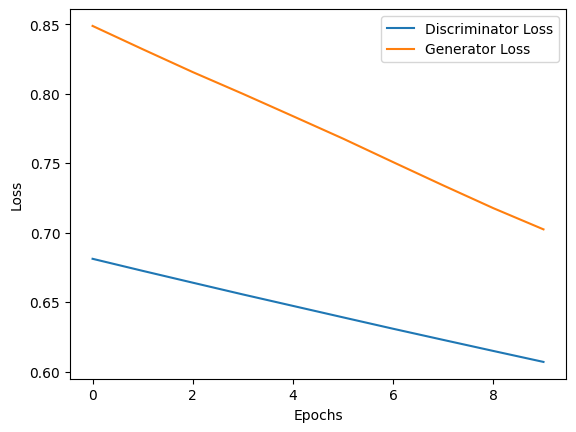

In [ ]:
#plot the loss function
plt.plot(range(len(D_losses)), D_losses, label='Discriminator Loss')
plt.plot(range(len(G_losses)), G_losses, label='Generator Loss')

# Adding labels to the axes
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
 generated = gen.predict(np.random.rand(train_mms.shape[0], train_mms.shape[1]))

10312/10312 [==============================] - 13s 1ms/step


In [ ]:
print(type(generated))
print(generated.shape)
print(generated)

<class 'numpy.ndarray'>
(329975, 6)
[[-0.1203796   0.32019123  0.19679351  0.12745766  0.5938495   0.30820253]
 [-0.39071947  0.4933455  -0.09355593  0.1787679   0.5922011   0.10327041]
 [-0.32575434  0.25142705 -0.15051207  0.14563854  0.4474688   0.26981974]
 ...
 [-0.25912032  0.04072921 -0.10169541 -0.04978021  0.2270484   0.35353208]
 [-0.18829834  0.0715346  -0.22573379 -0.08866867  0.20567681  0.3361015 ]
 [-0.25249562  0.40511495  0.07145333  0.1317669   0.571051    0.27128357]]


In [ ]:
generated_df = pd.DataFrame(scaler.inverse_transform(generated), index=train_mms.index, columns=train_mms.columns)
generated_df = generated_df.astype('int16').abs()

generated_df['Installation_zone'] = le_iz.inverse_transform(generated_df['Installation_zone'])
generated_df['Consumer_type'] = le_ct.inverse_transform(generated_df['Consumer_type'])
# generated_df['Consumer_number'] = le_cn.inverse_transform(generated_df['Consumer_number'])

generated_df.head()

,Year,Month,Consumer_type,Consumption,Consumer_number,Installation_zone
0,2012,4,domestic,634,16408,Installation_zone 22
1,2010,6,construction,889,16363,Installation_zone 13
2,2010,3,construction,724,12364,Installation_zone 20
3,2011,2,construction,59,5678,Installation_zone 19
4,2011,4,construction,569,11248,Installation_zone 12


In [ ]:
print(generated_df['Year'].unique())
print(generated_df['Month'].unique())

[2012 2010 2011 2007 2008 2009 2006 2013 2005]
[ 4  6  3  2  5  1  7 10  0  8  9 11 12]
